# **Section 1. Compressive sensing**

In [1]:
InputImage = "/content/InputImages"
CompressedImage = "/content/Compressed"
imagesize_reduce = (0.5,0.5) # image scaling for reconstructed for compressive sensing(uses sampling of 25% pixels of original image)

In [2]:
!pip install PyLBFGS

     |████████████████████████████████| 203 kB 7.2 MB/s 


In [3]:
!pip install spm-image


  Created wheel for spm-image: filename=spm_image-0.0.11-py3-none-any.whl size=31521 sha256=f493e2bb65365866595795846cbfe312577120525e6b9342f610dcb7ae3e4af2
  Stored in directory: /root/.cache/pip/wheels/c7/e4/3f/d9e9bc99410a6c4be4c47d31bd39b172b69f4b790b65910a0c
Successfully built spm-image


In [4]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import imageio
from PIL import Image
import lbfgs
import scipy.misc
from lbfgs import fmin_lbfgs
from skimage import io
from google.colab import files
import shutil

In [5]:
if not os.path.exists(InputImage):
  os.mkdir(InputImage)
if not os.path.exists(CompressedImage):
  os.mkdir(CompressedImage)

Upload your images in /content/InputImages before running subsequent cells

In [6]:
print('pls upload your images in /content/InputImages')

pls upload your images in /content/InputImages


In [7]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)


In [8]:


def evaluate(x, g):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)
    

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

# fractions of the scaled image to randomly sample at
sample_sizes = (0.25,)

for im in os.listdir(InputImage):
# read original image
  XorigIm = Image.open(os.path.join(InputImage,im))
  X= np.array(XorigIm)
  imagesize =(int(imagesize_reduce[1]* X.shape[1]),int(imagesize_reduce[0]* X.shape[0]))
  #print(imagesize)
  XorigIm = XorigIm.resize(imagesize)
  Xorig = np.array(XorigIm)
  ny,nx,nchan = Xorig.shape

  # for each sample size
  Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
  masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
# print(masks)
  for i,s in enumerate(sample_sizes):

      # create random sampling index vector
      k = round(nx * ny * s)
      ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

      # for each color channel
      for j in range(nchan):

          # extract channel
          X = Xorig[:,:,j].squeeze()

          # create images of mask (for visualization)
          Xm = 0 * np.ones(X.shape)
          Xm.T.flat[ri] = X.T.flat[ri]
          masks[i][:,:,j] = Xm

          # take random samples of image, store them in a vector b
          b = X.T.flat[ri].astype(float)
          rand = np.random.rand(nx*ny)/255

          # perform the L1 minimization in memory
          Xat2 = fmin_lbfgs(evaluate,rand,orthantwise_c=1,m=10)

          # transform the output back into the spatial domain
          Xat = Xat2.reshape(nx, ny).T # stack columns
          Xa = idct2(Xat)
          Z[i][:,:,j] = Xa.astype('uint8')
          Z= np.array(Z)

          io.imsave(str(os.path.join(CompressedImage,im)), Z[0]) 

/usr/local/lib/python3.7/dist-packages/lbfgs/__init__.py:182: UserWarning: When using OWL-QN, 'wolfe' is the only valid line_search. line_search has been set to 'wolfe'.
  warnings.warn("When using OWL-QN, 'wolfe' is the only valid line_search. line_search has been set to 'wolfe'.")


Download your reconstructed image from /content/Compressed

In [9]:
print("Please Download your reconstructed image from /content/Compressed")

Please Download your reconstructed image from /content/Compressed


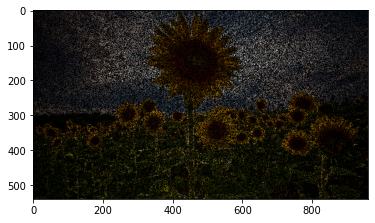

In [10]:
plt.imshow(masks[0])

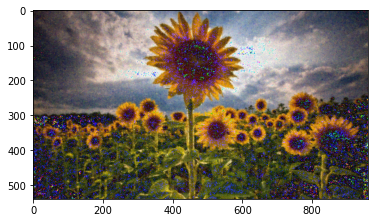

In [11]:
plt.imshow(Z[0])

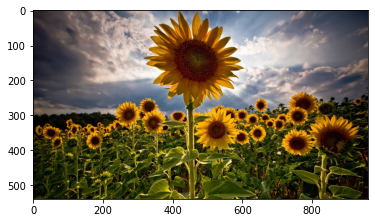

In [12]:
plt.imshow(XorigIm)

# New Section

#**Section 2: Super Resolution**

In [13]:
os.chdir('/content/')

In [14]:
%%capture
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

In [15]:
shutil.rmtree("/content/Real-ESRGAN/inputs/")
os.mkdir("/content/Real-ESRGAN/inputs/")

**Linking of the image**

In [16]:

upload_folder = '/content/Real-ESRGAN/inputs'
result_folder = '/content/Real-ESRGAN/results'
import os, shutil

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

#uploaded = files.upload()
for filename in os.listdir(CompressedImage):
  #print(filename)
  if filename[-3:]=='jpg' or filename[-3:]=='png' or filename[-4:] == 'jpeg' :
   dst_path = os.path.join(upload_folder, filename)
   print(f'move {filename} to {dst_path}')
   shutil.copy2(os.path.join(CompressedImage,filename), dst_path)

# # upload images
# uploaded = Image.open('/content/R_cs.jpg')
# # for filename in uploaded.keys():
# #   dst_path = os.path.join(upload_folder, filename)
# #   print(f'move {filename} to {dst_path}')
# #   shutil.move(filename, dst_path)

# dst_path = os.path.join(upload_folder, 'R_cs.jpg')
# print(dst_path)
# shutil.move('/content/R_cs.jpg', dst_path)
os.chdir('/content/Real-ESRGAN')

move 0.jpg to /content/Real-ESRGAN/inputs/0.jpg
move OIP.jpg to /content/Real-ESRGAN/inputs/OIP.jpg
move images-2.jpg to /content/Real-ESRGAN/inputs/images-2.jpg


In [17]:

!python inference_realesrgan.py -n RealESRGAN_x4plus -i inputs --outscale 2.0


Testing 0 0
tcmalloc: large alloc 2179891200 bytes == 0x561b7eeac000 @  0x7fa686c54b6b 0x7fa686c74379 0x7fa56f560cde 0x7fa56f562452 0x7fa5c11c1ab9 0x7fa5c11c2817 0x7fa5c1604dc9 0x7fa5c1cf07b3 0x7fa5c1d2b8e2 0x7fa5c1693f8b 0x7fa5c1cf712d 0x7fa5c1cf71c4 0x7fa5c1bd128a 0x7fa5c1692741 0x7fa5c1de213c 0x7fa5c18b1012 0x7fa5c33f1621 0x7fa5c33f1aed 0x7fa5c19193b3 0x7fa66ad4dd4c 0x561b173ba4b0 0x561b173ba240 0x561b1742e0f3 0x561b17428ced 0x561b173bbbda 0x561b1742a737 0x561b173bc039 0x561b173bc698 0x561b1742afe4 0x561b174289ee 0x561b173bc271
tcmalloc: large alloc 2179891200 bytes == 0x561c00d94000 @  0x7fa686c54b6b 0x7fa686c74379 0x7fa56f560cde 0x7fa56f562452 0x7fa5c1812f48 0x7fa5c12dd7c9 0x7fa5c12ddd60 0x7fa5c1808b7a 0x7fa5c1809077 0x7fa5c1804976 0x7fa5c1805417 0x7fa5c1de12e2 0x7fa5c18adbab 0x7fa5c3210dbd 0x7fa5c32116d2 0x7fa5c18e9c66 0x7fa5c1389e70 0x7fa5c1e6121a 0x7fa5c18cff8c 0x7fa5c1382d9b 0x7fa5c1e6117a 0x7fa5c18cf2a7 0x7fa5c138296a 0x7fa5c1e61502 0x7fa5c1c58fd6 0x7fa66ac75cef 0x561b173ba4b

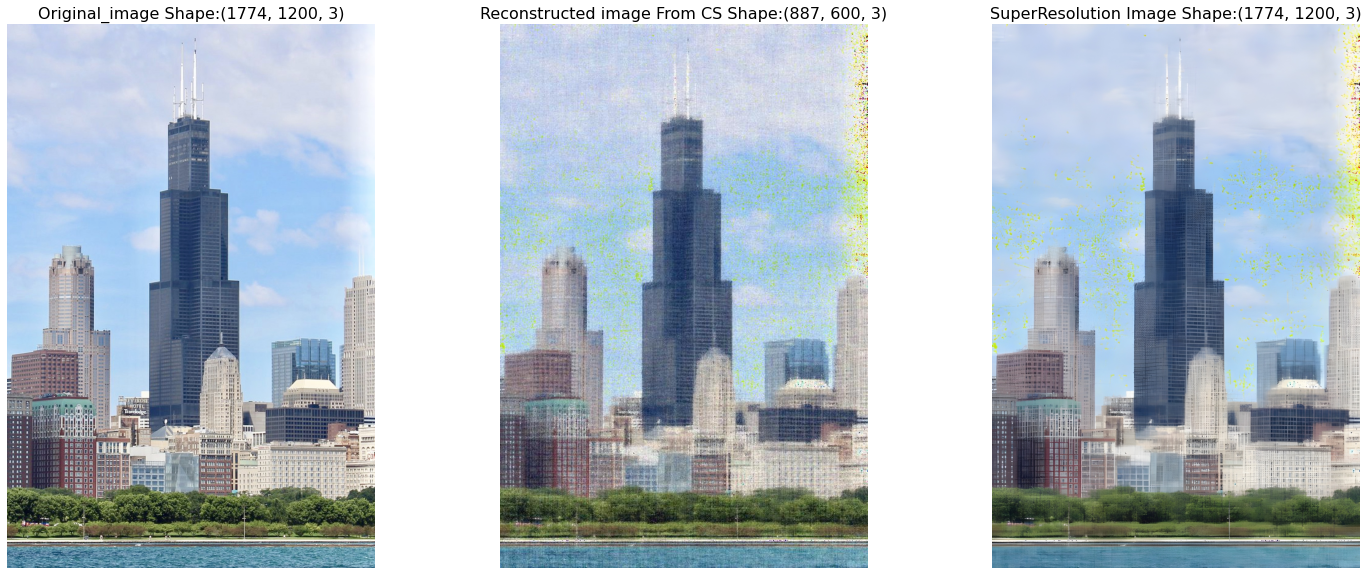

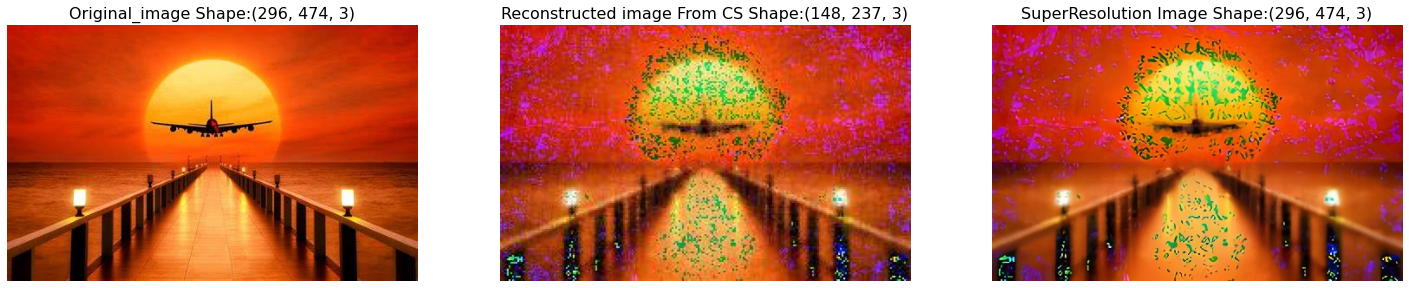

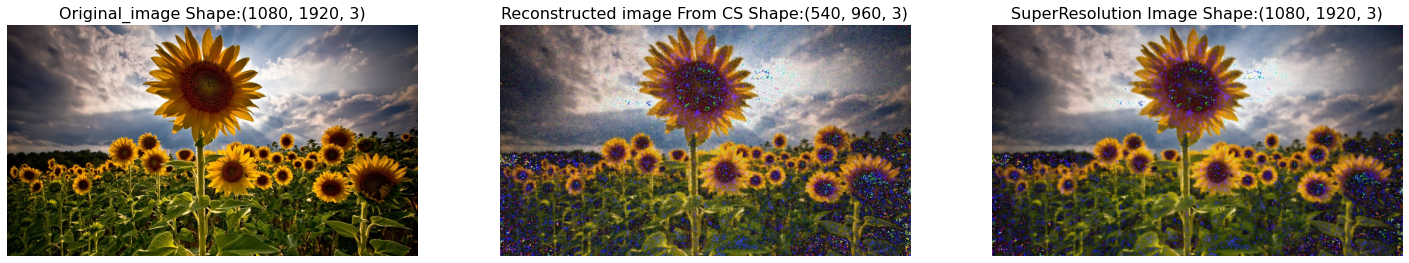

In [18]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img0,img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax0 = fig.add_subplot(1,3,1)
  plt.title('Original_image Shape:'+ str(img0.shape), fontsize=16)
  ax0.axis('off')
  ax1 = fig.add_subplot(1, 3, 2) 
  plt.title('Reconstructed image From CS Shape:'+ str(img1.shape), fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 3, 3)
  plt.title('SuperResolution Image Shape:'+ str(img2.shape), fontsize=16)
  ax2.axis('off')
  ax0.imshow(img0)
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img


# display each image in the upload folder
import os
import glob
original_folder = InputImage
input_folder = CompressedImage
result_folder = '/content/Real-ESRGAN/results'
orginal_list = sorted(glob.glob(os.path.join(original_folder, '*')))
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
#print ("Hi", input_list, output_list)
for original_path, input_path, output_path in zip(orginal_list,input_list, output_list):
  #print('12312312', input_path, output_path)
  img_original = imread(original_path)
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_original,img_input, img_output)


Download your Super resolution image from /content/Real-ESRGAN/results

In [19]:
pip install pytorch-msssim

In [20]:
#ssim comparison
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

In [21]:
TorchOrginal = '/content/TorchOrginal'
TorchCompressed ='/content/TorchCompressed'
if os.path.exists(TorchOrginal):
  shutil.rmtree(TorchOrginal)
if os.path.exists(TorchCompressed):
  shutil.rmtree(TorchCompressed)
os.mkdir(TorchOrginal)
os.mkdir(TorchCompressed)
os.mkdir(TorchOrginal+'/Test')
os.mkdir(TorchCompressed+'/Test')

transform1 =Compose([
    Resize(size=(64,64)),
    ToTensor()
])

In [22]:
for filename in os.listdir(InputImage):
  #print(filename)
  if filename[-3:]=='jpg' or filename[-3:]=='png' or filename[-4:] == 'jpeg' :
   dst_path = TorchOrginal+'/Test'
   print(f'move {filename} to {dst_path}')
   shutil.copy2(os.path.join(InputImage,filename), dst_path)

move 0.jpg to /content/TorchOrginal/Test
move OIP.jpg to /content/TorchOrginal/Test
move images-2.jpg to /content/TorchOrginal/Test


In [23]:
for filename in os.listdir(CompressedImage):
  #print(filename)
  if filename[-3:]=='jpg' or filename[-3:]=='png' or filename[-4:] == 'jpeg' :
   dst_path = TorchCompressed+'/Test'
   print(f'move {filename} to {dst_path}')
   shutil.copy2(os.path.join(CompressedImage,filename), dst_path)

move 0.jpg to /content/TorchCompressed/Test
move OIP.jpg to /content/TorchCompressed/Test
move images-2.jpg to /content/TorchCompressed/Test


In [24]:
org = datasets.ImageFolder(TorchOrginal, transform=transform1)

In [25]:
Reconstructed = datasets.ImageFolder( TorchCompressed, transform=transform1)

In [26]:
ssimMetric= 0
for i in range(len(org)):
  OrgTestImages,no = org[i]
  Rec,no = Reconstructed[i]
  OrgTestImages =torch.unsqueeze(OrgTestImages,0)
  Rec =torch.unsqueeze(Rec,0)
  ssimMetric = ssimMetric + ssim(Rec,OrgTestImages)
ssimMetric = ssimMetric/len(org)
print('SSIM Metric in Test Images are :',ssimMetric )

SSIM Metric in Test Images are : tensor(0.9994)
